## L-mode H-mode Classifier
- In this notebook a single camera model will be created and trained. 
- First import ResNet model, modify its fc. layer and train this fc.layer
- Then train the whole model
- We can either train the model on imgs from RIS1 camera or RIS2, and then ensemble these models in `ModelEnsembling.ipynb`

In [1]:
import os
import re
import time 
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt
from torch import cuda
import torchvision
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import pytorch_lightning as pl

import confinement_mode_classifier as cmc

In [2]:
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

#Where are csv spreadsheets with time, mode, img_path, h_alpha columns are saved
data_dir_path = f'{path}/data/LH_alpha'
file_names = os.listdir(data_dir_path)


## Constants

In [10]:
ris_option = 'RIS1'
num_workers = 0
num_epochs_for_fc = 1
num_epochs_for_all_layers = 1
num_classes = 2
batch_size = 32
learning_rate_min = 0.001
learning_rate_max = 0.01
comment_for_model_name = 'DUMMY_run'
random_seed = 42
augmentation = True

### Create dataloader
- It is convinient to have dloaders in dictionary in order to easily switch between training and validation

In [11]:
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_ris1'] if ris_option == 'RIS1' else shot_usage['used_for_ris2']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']

shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shot_numbers, shots_for_training, shots_for_testing, 
                                                                shots_for_validation, use_ELMS=False, ris_option=ris_option)


test_dataloader = cmc.get_dloader(test_df, path, batch_size, balance_data=False, 
                                    shuffle=False, num_workers=num_workers, 
                                    augmentation=False)

val_dataloader = cmc.get_dloader(val_df, path, batch_size, balance_data=True, 
                                    shuffle=False, num_workers=num_workers, 
                                    augmentation=augmentation)

train_dataloader = cmc.get_dloader(train_df, path, batch_size, balance_data=True, 
                                    shuffle=False, num_workers=num_workers, 
                                    augmentation=augmentation)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

Time stamp will be added to the model's folder name

In [19]:
sample_img = next(iter(train_dataloader))['img'][1]

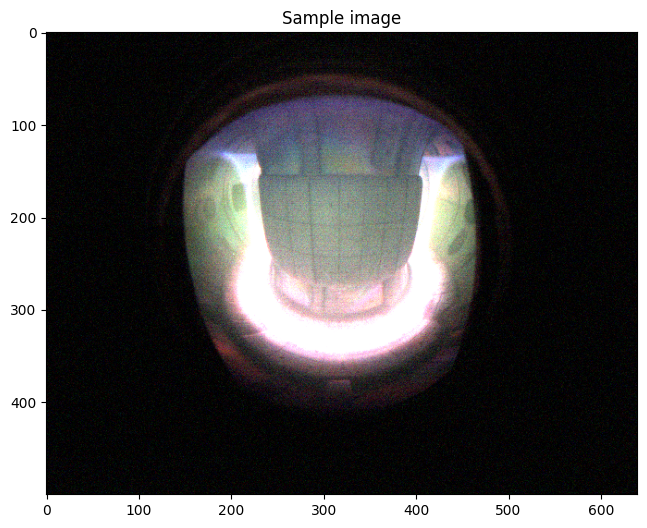

In [20]:
cmc.imshow(sample_img, title='Sample image')

In [8]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%y-%m-%d, %H-%M-%S ") + comment_for_model_name
writer = SummaryWriter(f'runs/{timestamp}_last_fc')

### Import ResNet pretrained model
 And freeze all layers except last f.c. layer


In [14]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in pretrained_model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, num_classes) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

In [10]:
sample_input = next(iter(train_dataloader))['img']
writer.add_graph(pretrained_model, sample_input.float().to(device))

### Train last fc of the model

In [15]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=learning_rate_min)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate_max, total_steps=num_epochs_for_fc) #!!!

# Model will be saved to this folder along with metrics and tensorboard scalars
model_path = Path(f'{path}/runs/{timestamp}_last_fc/model.pt')

#### Train the last fully connected layer########################
model = cmc.train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, 
                    dataloaders, writer, dataset_sizes, num_epochs=num_epochs_for_fc, 
                    chkpt_path=model_path.with_name(f'{model_path.stem}_chkpt{model_path.suffix}'))

hyperparameters = {
'batch_size': batch_size,
'num_epochs': num_epochs_for_fc,
'optimizer': optimizer.__class__.__name__,
'criterion': criterion.__class__.__name__,
'learning_rate_max': learning_rate_max,
'scheduler': exp_lr_scheduler.__class__.__name__,
'shots_for_testing': shots_for_testing.values.tolist(),
'shots_for_validation': shots_for_validation.values.tolist(),
'shots_for_training': shots_for_training.values.tolist(),
'ris_option': ris_option,
'num_classes': num_classes,
'second_image': 'None',
'augmentation': "applied" if augmentation else "no augmentation",
'random_seed': random_seed
}


torch.save(model.state_dict(), model_path)

Epoch 1/1
----------


100%|██████████| 1629/1629 [02:50<00:00,  9.54it/s]


train Loss: 0.7222 Acc: 0.4831


100%|██████████| 446/446 [00:48<00:00,  9.28it/s]


val Loss: 0.7219 Acc: 0.4967
Training complete in 3m 39s
Best val Acc: 0.496700


### Test model

100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


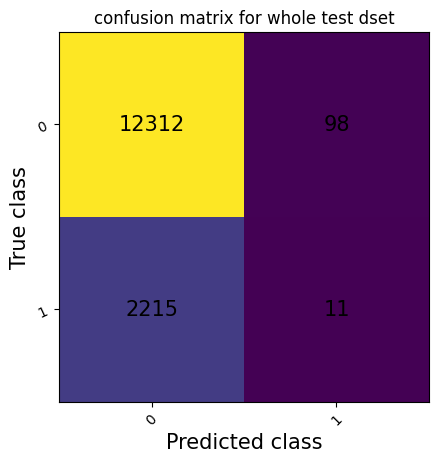

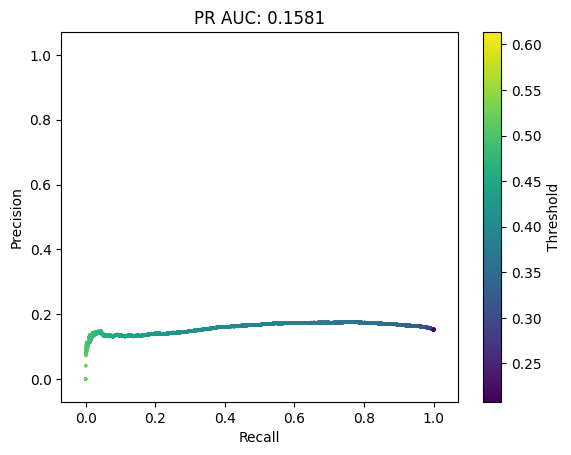

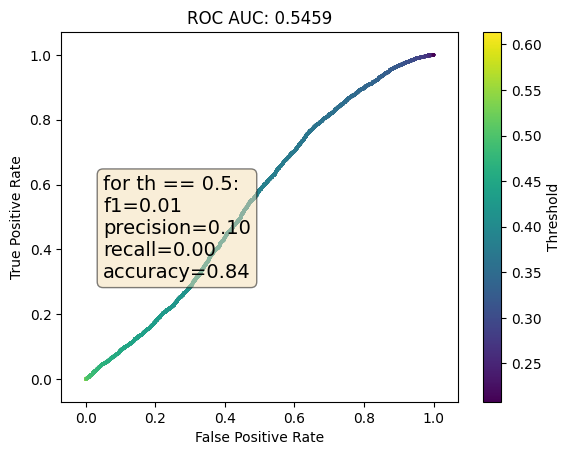

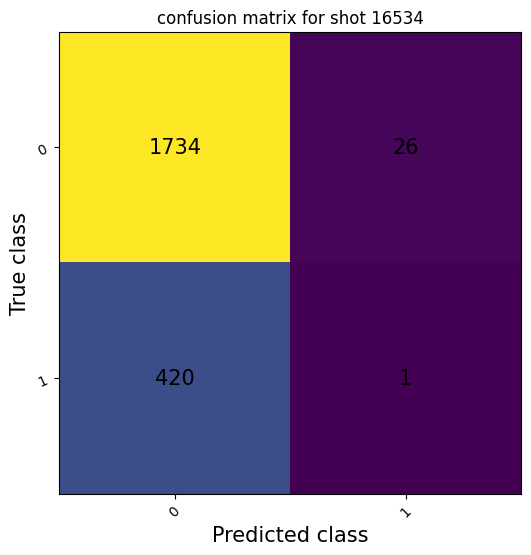

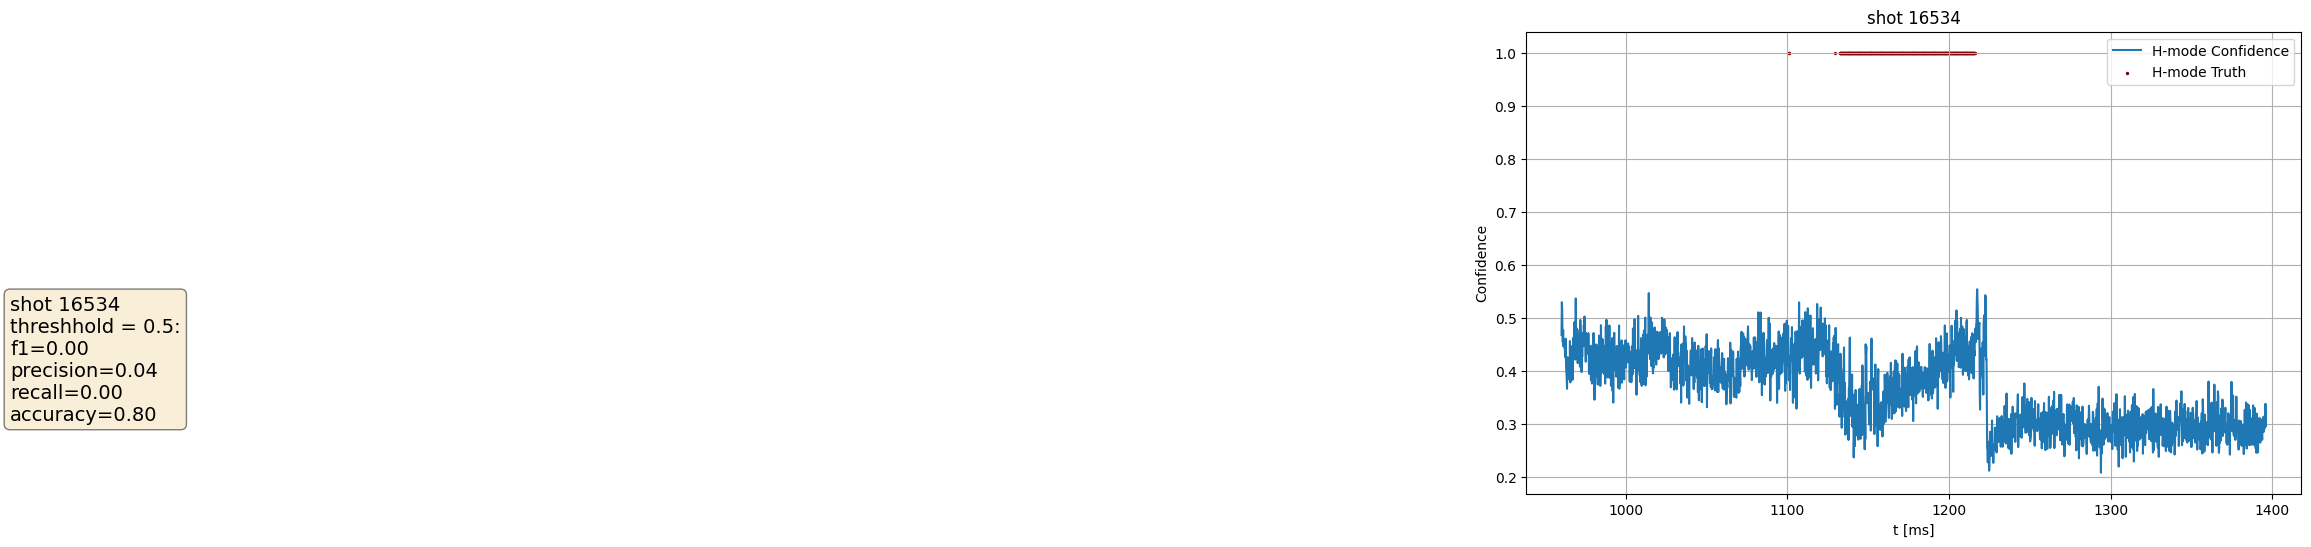

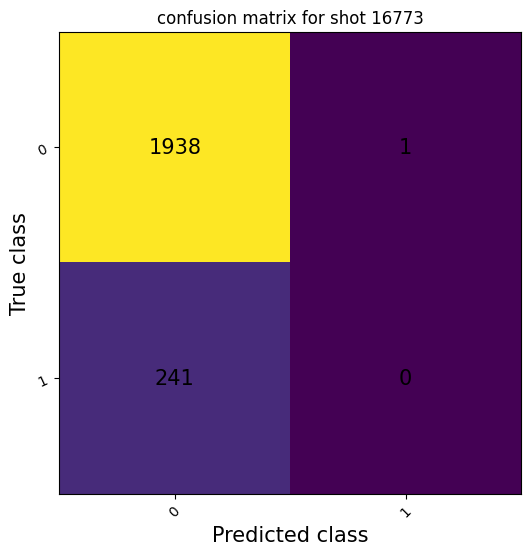

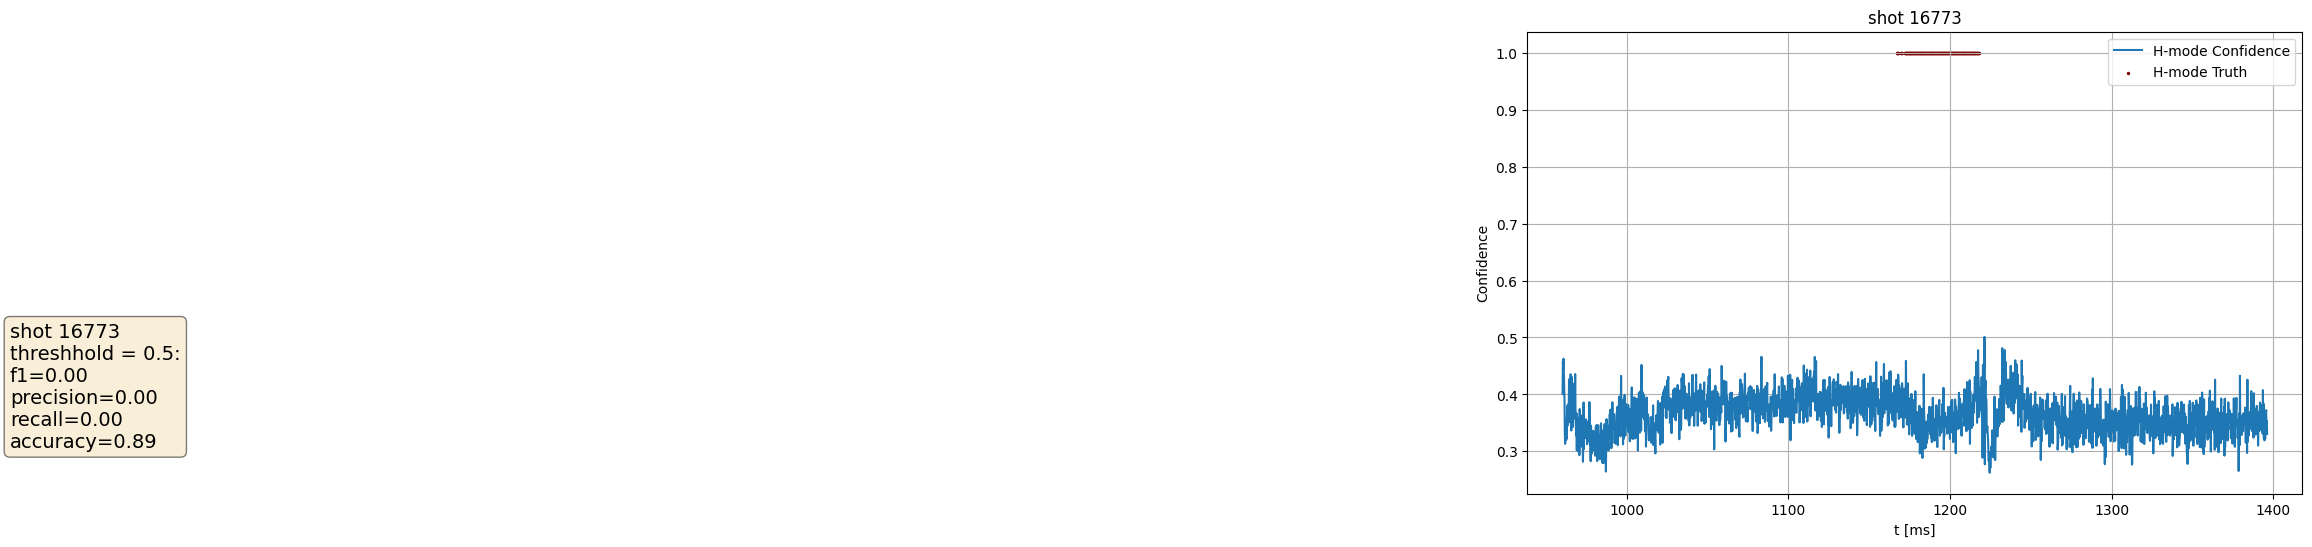

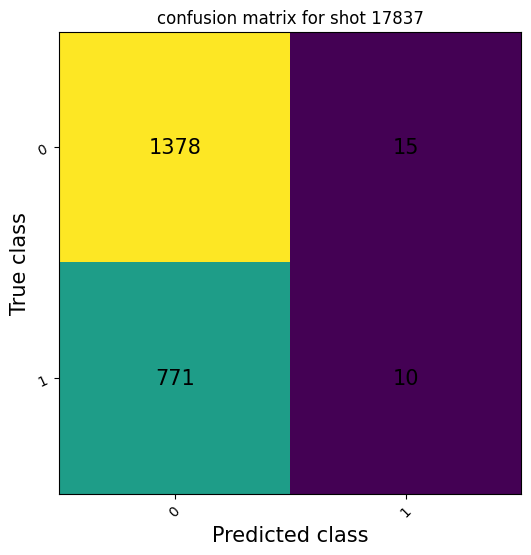

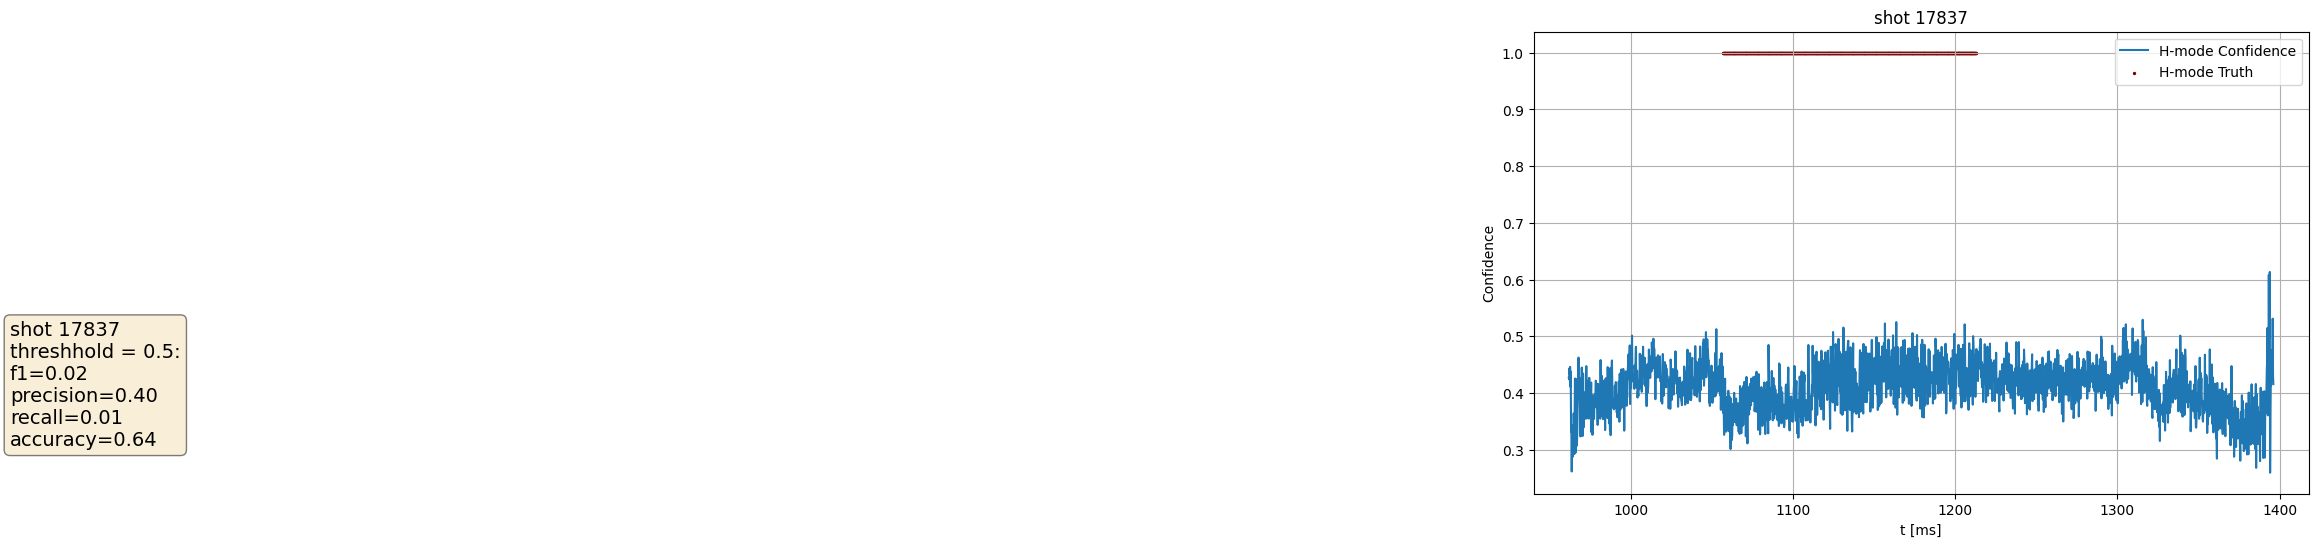

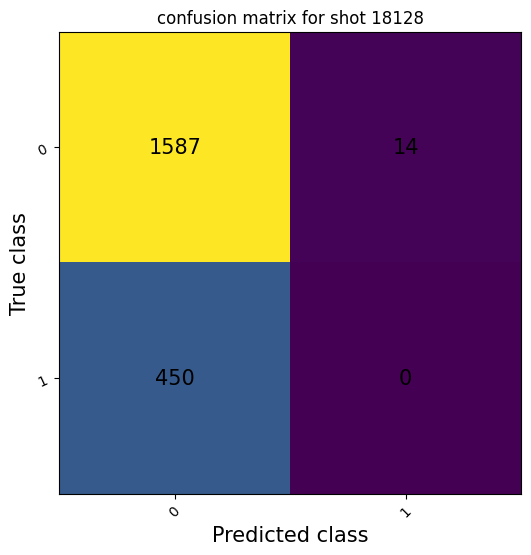

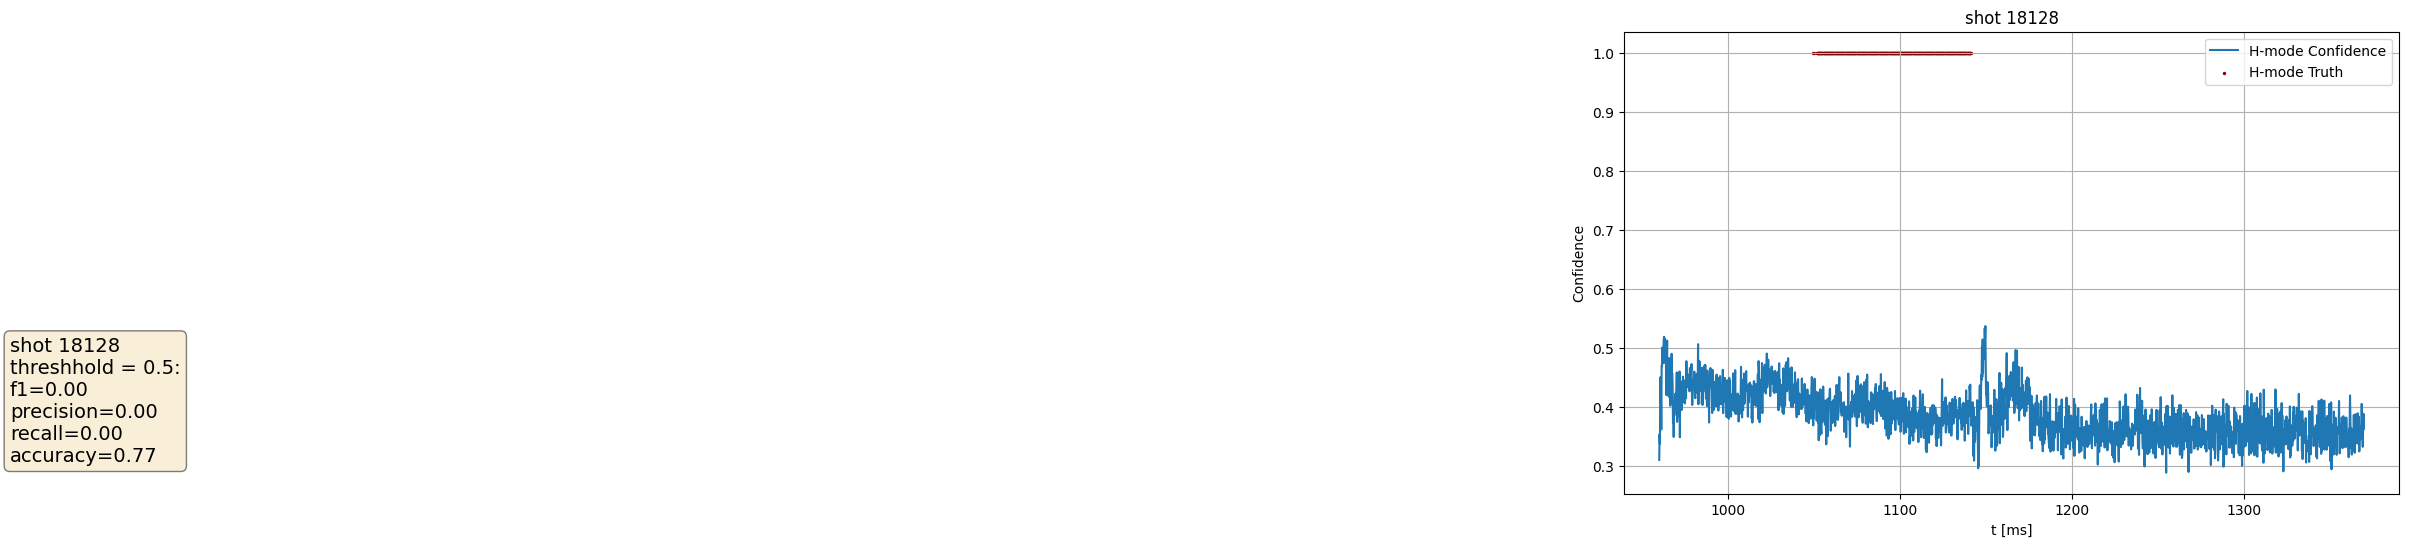

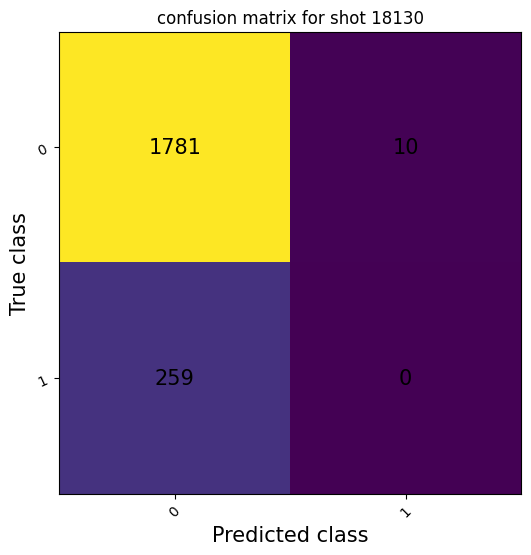

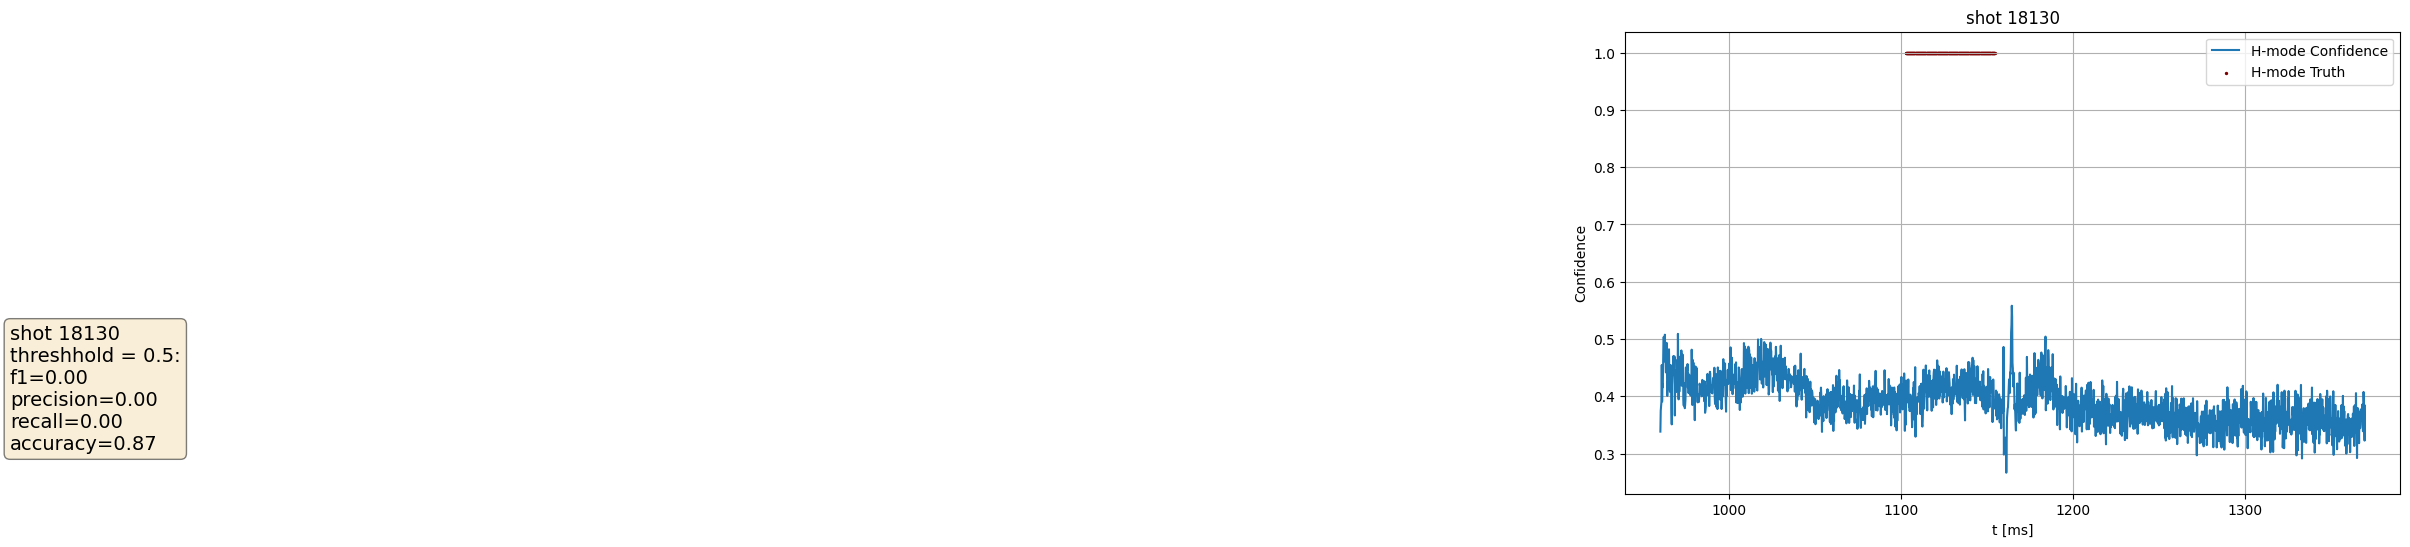

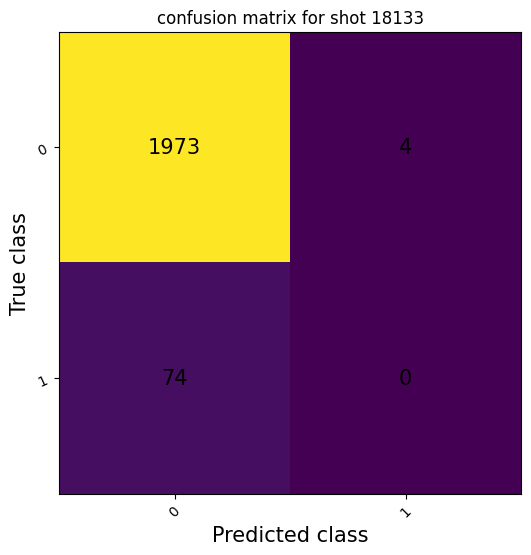

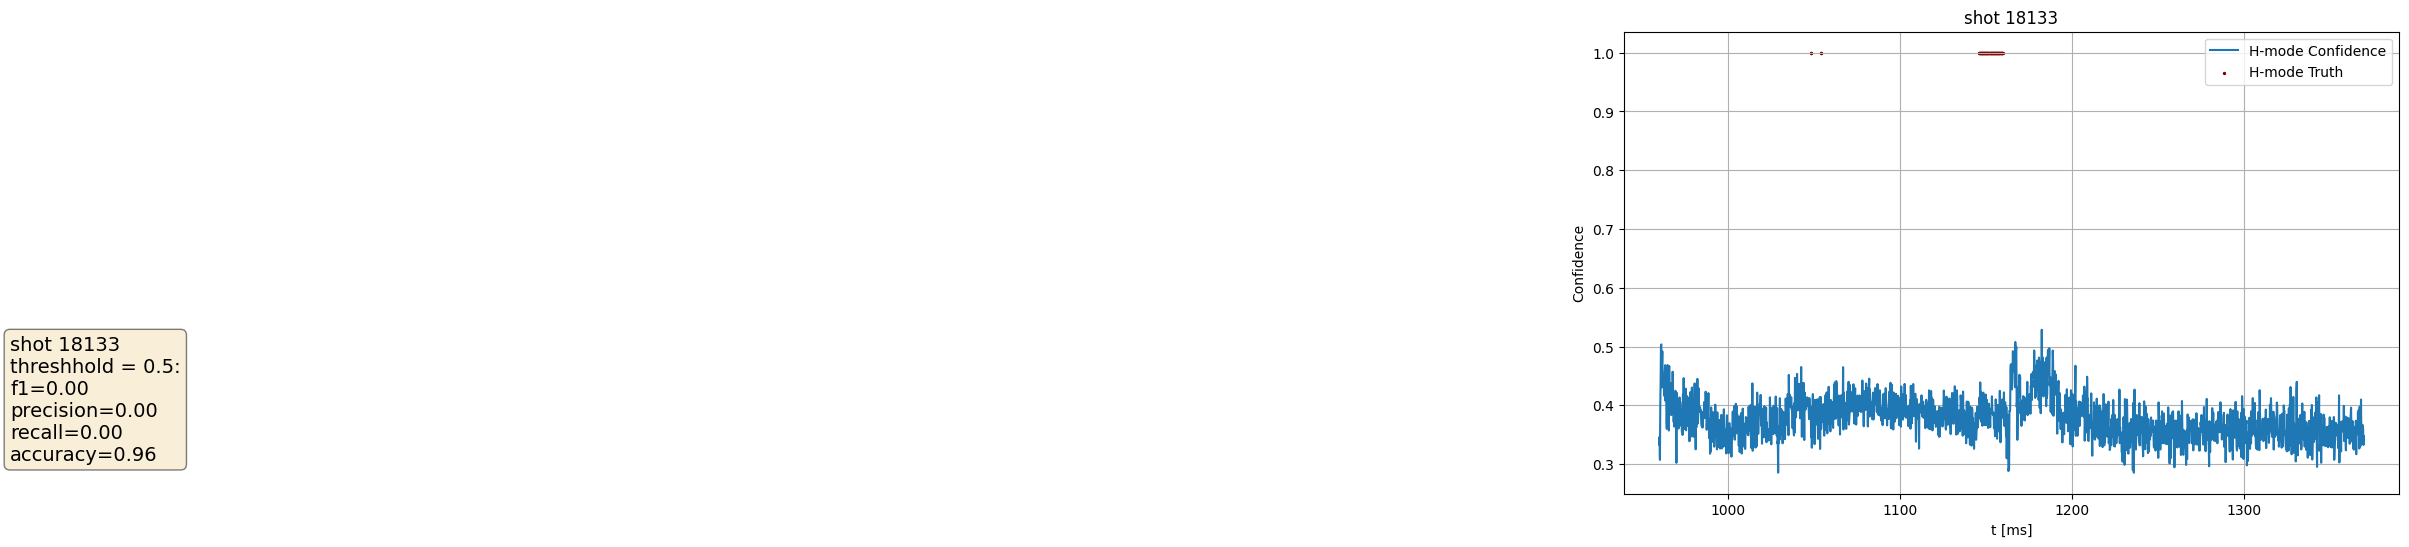

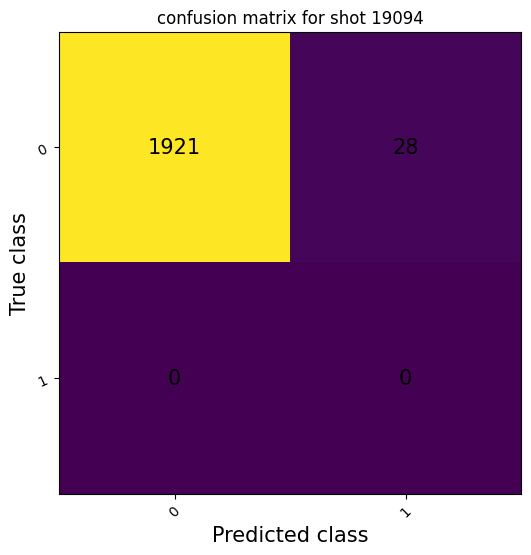

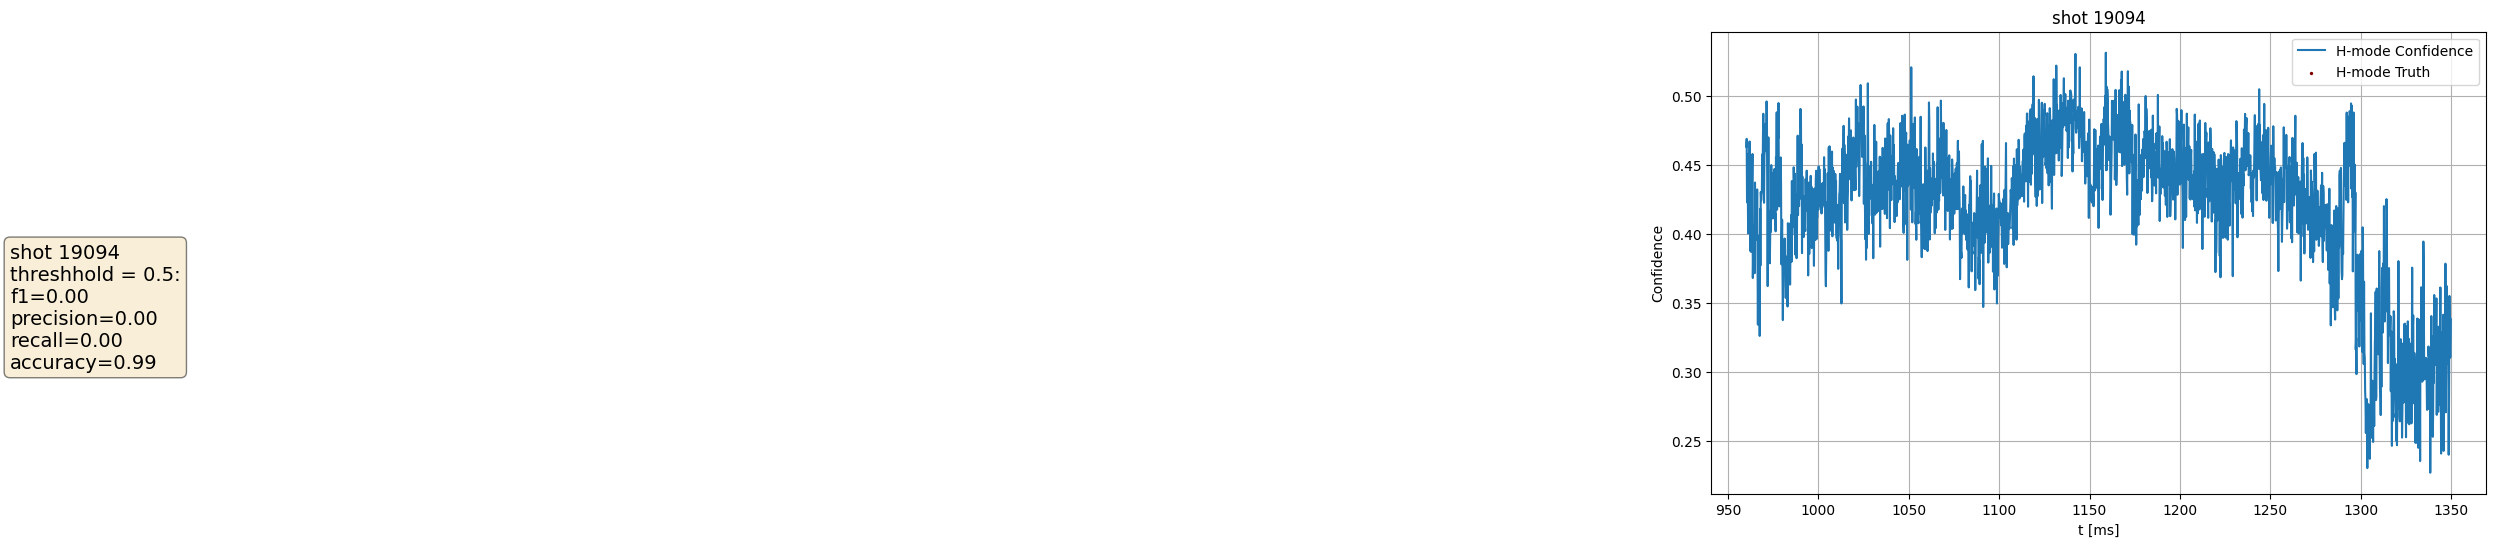

In [16]:
metrics = cmc.test_model(f'runs/{timestamp}_last_fc', model, test_dataloader, comment='', writer=writer)

shots_for_testing = shots_for_testing.values.tolist()
img_path = cmc.per_shot_test(path=f'{path}/runs/{timestamp}_last_fc/', 
                            shots=shots_for_testing, results_df=metrics['prediction_df'], writer=writer)


### Train the whole model

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=learning_rate_min)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate_max, total_steps=num_epochs_for_all_layers) #!!!

writer = SummaryWriter(f'runs/{timestamp}_all_layers')
for param in model.parameters():
    param.requires_grad = True

model_path = Path(f'{path}/runs/{timestamp}_all_layers/model.pt')

model = cmc.train_model(model, criterion, optimizer, exp_lr_scheduler, 
                        dataloaders, writer, dataset_sizes, num_epochs=num_epochs_for_all_layers,
                        chkpt_path=model_path.with_name(f'{model_path.stem}_chkpt{model_path.suffix}'))

torch.save(model.state_dict(), model_path)


### Test model with all layers trained

In [ ]:
hyperparameters = {
'batch_size': batch_size,
'num_epochs': num_epochs_for_fc,
'optimizer': optimizer.__class__.__name__,
'criterion': criterion.__class__.__name__,
'learning_rate_max': learning_rate_max,
'scheduler': exp_lr_scheduler.__class__.__name__,
'shots_for_testing': shots_for_testing.values.tolist(),
'shots_for_validation': shots_for_validation.values.tolist(),
'shots_for_training': shots_for_training.values.tolist(),
'ris_option': ris_option,
'num_classes': num_classes,
'second_image': 'None',
'augmentation': "applied" if augmentation else "no augmentation",
'random_seed': random_seed
}

#### Test the model############################################
metrics = cmc.test_model(f'runs/{timestamp}_all_layers', model, test_dataloader, comment='', writer=writer)

img_path = cmc.per_shot_test(path=f'{path}/runs/{timestamp}_all_layers/', 
                            shots=shots_for_testing, results_df=metrics['prediction_df'], writer=writer)

writer.add_hparams(hyperparameters, {'Accuracy on test_dataset': metrics['accuracy'], 
                                        'F1 metric on test_dataset':metrics['f1'], 
                                        'Precision on test_dataset':metrics['precision'], 
                                        'Recall on test_dataset':metrics['recall']})
writer.close()